# Ant sorting

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
from itertools import combinations, combinations_with_replacement
from math import dist

In [2]:
class Ant:
    """Agent that moves object on the grid"""
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.object = 0
        self.laden = False

    def pickup(self, object):
        self.object = object
        self.laden = True
        
    def drop(self):
        self.object = 0
        self.laden = False
        
    def move(self, ants):
        neighbours = von_neumann_neighbourhood(self.x, self.y)
        # 2 ants can't occupy the same cell
        for ant in ants:
            if (ant.x, ant.y) in neighbours:
                neighbours.remove((ant.x, ant.y))
        if len(neighbours) >= 1:
            self.x, self.y = neighbours[random.randint(0, len(neighbours) - 1)]
        

In [3]:
def von_neumann_neighbourhood(x, y):
    """return coordinates of all cells in the Von Neumann neighbourhood of the input cell"""
    
    neighbours = []
    if x - 1 >= 0:
        neighbours.append((x - 1, y))
    if x + 1 < grid_size:
        neighbours.append((x + 1, y))
    if y - 1 >= 0:
        neighbours.append((x, y - 1))
    if y + 1 < grid_size:
        neighbours.append((x, y + 1))
        
    return neighbours

In [4]:
def dissimilarity(object_o, object_n):
    """calculate dissimilarity between objects"""
    if object_o == object_n:
        dis = 0
    else:
        dis = 1
    return dis

In [5]:
def local_density(x, y, object, grid, alpha):
    """calculate local density
        x, y = coordinates of the cell
        object = object the ant is holding"""
    
    neighbourhood = von_neumann_neighbourhood(x, y)
    s2 = len(neighbourhood) + 1
    similarity = 0
    
    for x_n, y_n in neighbourhood:
        similarity += 1 - dissimilarity(object, grid[x_n, y_n])/alpha
        
    return max(0, similarity/s2)

In [6]:
def pickup_probability(local_density, k1):
    """calculate pickup probability"""
    
    return (k1/(k1 + local_density))**2

In [7]:
def drop_probability(local_density, k2):
    """calculate drop probability"""
    
    if local_density < k2:
        probability = 2*local_density
    else:
        probability = 1
        
    return probability

## Simulation

In [8]:
grid_size = 25
ant_density = 0.05
object_density = 0.25
n_object_types = 5
t_total = 10000
k1 = 0.1
k2 = 0.15
alpha = 0.95

In [9]:
def initiate_grid(grid_size, object_density, n_object_types):
    """intiate the grid with objects"""
    
    grid = np.zeros((grid_size, grid_size), dtype=int)
    n_objects = int(object_density*grid_size**2)
    
    for object in range(n_objects):
        color = random.randint(1, n_object_types)
        x = random.randint(0, grid_size - 1)
        y = random.randint(0, grid_size - 1)
        grid[x, y] = color
        
    print(f"There are {n_objects} objects on the grid.")    
    return grid

In [10]:
def initiate_ants(grid_size, ant_density):
    """intiate the ants"""

    n_ants = int(ant_density*grid_size**2)
        
    ants = []
    for ant in range(n_ants):
        x = random.randint(0, grid_size - 1)
        y = random.randint(0, grid_size - 1)
        ants.append(Ant(x, y))
        
    print(f"There are {n_ants} ants on the grid.")    
    return ants

In [11]:
original_grid = initiate_grid(grid_size, object_density, n_object_types)

There are 156 objects on the grid.


In [12]:
ants = initiate_ants(grid_size, ant_density)

There are 31 ants on the grid.


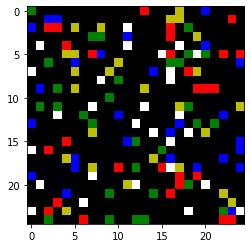

In [13]:
plt.imshow(original_grid, cmap = matplotlib.colors.ListedColormap(['k', 'r', 'y', 'b', 'w', 'g']));

In [ ]:
densities = []
for color in range(n_object_types):
    for x in range(grid_size):
        for y in range(grid_size):
            densities.append(local_density(x, y, color, original_grid, alpha))
plt.hist(densities); print("The local density distribution for all colors in the original grid")

In [15]:
def run_simulation(original_grid, ants, t_total, k1, k2, alpha):

    grids = []
    grid = np.copy(original_grid)
    grids.append(np.copy(grid))

    for t in range(1, t_total):
        for ant in ants:

            if (ant.laden == False) & (grid[ant.x, ant.y] != 0):
                p_pickup = pickup_probability(local_density(ant.x, ant.y, grid[ant.x, ant.y], grid, alpha), k1)

                if random.random() <= p_pickup:
                    ant.pickup(grid[ant.x, ant.y])
                    grid[ant.x, ant.y] = 0

            elif (ant.laden == True) & (grid[ant.x, ant.y] == 0):
                p_drop = drop_probability(local_density(ant.x, ant.y, ant.object, grid, alpha), k2)

                if random.random() <= p_drop:
                    grid[ant.x, ant.y] = ant.object
                    ant.drop()

            ant.move(ants)

        if t % 1000 == 0:
            grids.append(np.copy(grid))

    # forcing ants to drop their objects in place after simulation
    for ant in ants:
        while ant.laden:
            if grid[ant.x, ant.y] == 0:
                grid[ant.x, ant.y] = ant.object
                ant.drop()
            else:
                ant.move(ants)
                
    grids.append(np.copy(grid))
            
    return grid, grids

In [16]:
grid, grids0 = run_simulation(original_grid, ants, t_total, k1, k2, alpha)

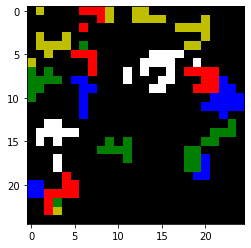

In [17]:
plt.imshow(grid, cmap = matplotlib.colors.ListedColormap(['k', 'r', 'y', 'b', 'w', 'g']));

# Clustered ant sorting

In [18]:
class Cluster:
    """cluster object"""
    
    def __init__(self):
        self.x = []
        self.y = []
        self.positions = []
        self.objects = []

    def add_object(self, x, y, object):
        self.x.append(x)
        self.y.append(y)
        self.positions.append((x, y))
        self.objects.append(object)

In [19]:
def calculate_clusters(grid):
    """Converts object into clusters, adjacent objects of the same type are put into the same cluster"""
    
    # clusters for objects
    clusters = []
    cluster_grid = np.zeros((grid_size, grid_size), dtype=int)
    # clusters for zeros
    zero_clusters = []
    zero_cluster_grid = np.zeros((grid_size, grid_size), dtype=int)
    
    #iterate over all grid cells
    for x in range(grid_size):
        for y in range(grid_size):
            
            # if it's an object
            if grid[x, y] != 0:

                # if the object is not in a cluster
                if cluster_grid[x, y] == 0:

                    # make a cluster
                    clusters.append(Cluster())
                    clusters[len(clusters) - 1].add_object(x, y, grid[x, y])
                    cluster_grid[x, y] = len(clusters)

                    # add neighboring positions to the cluster using greedy search
                    done = False
                    already_seen = []
                    while not done:
                        added = 0
                        for x_i, y_i in clusters[len(clusters) - 1].positions:
                            if (x_i, y_i) not in already_seen:
                                already_seen.append((x_i, y_i))
                                neighbors = von_neumann_neighbourhood(x_i, y_i)
                                same_type = [n for n in neighbors if grid[n[0], n[1]] == clusters[len(clusters) - 1].objects[0]]
                                for s in same_type:
                                    clusters[len(clusters) - 1].add_object(s[0], s[1], grid[s[0], s[1]])
                                    cluster_grid[s[0], s[1]] = len(clusters)
                                    added += 1
                        if added == 0:
                            done = True

            # if it's not an object, make clusters of zeros (the free space), useful for dropping clusters later on
            else:
                # if it's is not in a cluster
                if zero_cluster_grid[x, y] == 0:

                    # make a cluster
                    zero_clusters.append(Cluster())
                    zero_clusters[len(zero_clusters) - 1].add_object(x, y, grid[x, y])
                    zero_cluster_grid[x, y] = len(zero_clusters)

                    # add neighboring positions to the cluster using greedy search
                    done = False
                    already_seen = []
                    while not done:
                        added = 0
                        for x_i, y_i in zero_clusters[len(zero_clusters) - 1].positions:
                            if (x_i, y_i) not in already_seen:
                                already_seen.append((x_i, y_i))
                                neighbors = von_neumann_neighbourhood(x_i, y_i)
                                same_type = [n for n in neighbors if grid[n[0], n[1]] == 0]
                                for s in same_type:
                                    zero_clusters[len(zero_clusters) - 1].add_object(s[0], s[1], grid[s[0], s[1]])
                                    zero_cluster_grid[s[0], s[1]] = len(zero_clusters)
                                    added += 1
                        if added == 0:
                            done = True

        
                          
    return clusters, cluster_grid, zero_clusters, zero_cluster_grid

In [20]:
clusters, cluster_grid, zero_clusters, zero_cluster_grid = calculate_clusters(grid)

In [21]:
len(clusters)

28

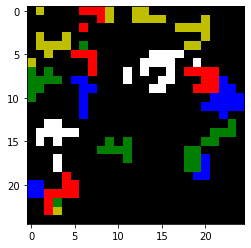

In [22]:
plt.imshow(grid, cmap = matplotlib.colors.ListedColormap(['k', 'r', 'y', 'b', 'w', 'g']));

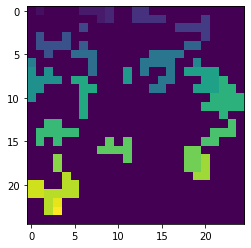

In [23]:
plt.imshow(cluster_grid);

In [24]:
len(zero_clusters)

1

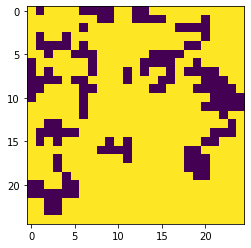

In [25]:
plt.imshow(zero_cluster_grid);

In [26]:
def Von_Neumann_drop(ant, grid, alpha): 
    """Von Neumann drop method to drop clusters"""
    success = True
    
    #get location of ant
    x, y = ant.x, ant.y
    
    previous_positions = [(x, y)]
    
    #virtual drop of first object in cluster
    temp_grid = np.copy(grid)
    temp_grid[x, y] = ant.object.objects[0]
    
    #iterative virtual drops of next objects in cluster
    for i in range(1, len(ant.object.objects)):
        
        #get location of all neighbours
        neighbours = von_neumann_neighbourhood(x, y)
        max_s = 0
        max_x = float("nan")
        max_y = float("nan")

        #iterate over neighbours
        for x_n, y_n in neighbours:
            #if cell is empty 
            if temp_grid[x_n, y_n] == 0:
                #calculate local density of next object in cluster
                s = local_density(x_n, y_n, ant.object.objects[i], temp_grid, alpha)
                #check if this neighbour is the current best neighbour
                if s > max_s:
                    max_s = s
                    max_x = x_n
                    max_y = y_n
        
        if np.isnan(max_x) != True:
            #virtual drop of object on best neighbour
            temp_grid[max_x, max_y] = ant.object.objects[i]
        
            #"move" to the best neighbour
            x = max_x
            y = max_y
            previous_positions = [(max_x, max_y)]
            i = 0
            
        else:
            success = False
            break
            
    return success, temp_grid

## Simulation

In [27]:
def run_cluster_simulation(original_grid, ants, t_total, k1, k2, alpha):

    grids = []
    grid = np.copy(original_grid)
    grids.append(np.copy(grid))
    clusters, cluster_grid, zero_clusters, zero_cluster_grid = calculate_clusters(grid)
    ant_timer = 0
    maxtime = grid_size**2

    for t in range(1, t_total):

        # keep track of how many timesteps no clusters are dropped for surrounded cluster deadlock
        ant_timer += 1

        for ant in ants:

            # pickup
            if (ant.laden == False) and (grid[ant.x, ant.y] != 0):     

                # make sure ant doesn't pick up the last cluster of that type to avoid empty grid deadlock
                if sum([grid[ant.x, ant.y] == cluster.objects[0] for cluster in clusters]) > 1: 

                    p_pickup = pickup_probability(local_density(ant.x, ant.y, grid[ant.x, ant.y], grid, alpha), k1)            
                    if random.random() <= p_pickup:
                        cluster = clusters[int(cluster_grid[ant.x, ant.y]) - 1]
                        ant.pickup(cluster)          

                        # remove cluster & objects from the grid
                        for i in range(len(cluster.positions)):
                            grid[cluster.x[i], cluster.y[i]] = 0     

            # drop
            elif (ant.laden == True) and (grid[ant.x, ant.y] == 0):          
                p_drop = drop_probability(local_density(ant.x, ant.y, ant.object.objects[0], grid, alpha), k2)     
                if random.random() <= p_drop: 

                    # find the zero cluster that the ant is currently in
                    for zero_cluster in zero_clusters:
                         if (ant.x, ant.y) in zero_cluster.positions:
                            break

                    # only drop if the free space (zero cluster) is large enough to hold the cluster that the ant is carrying
                    if len(ant.object.objects) <= len(zero_cluster.objects):
                        # Neumann drop the cluster             
                        success, temp_grid = Von_Neumann_drop(ant, grid, alpha)
                        if success:
                            grid = np.copy(temp_grid)
                            ant.drop()
                            ant_timer = 0

            # if no clusters have been dropped for too long, force ants to walk around until they drop their clusters
            # to avoid surrounded cluster deadlock
            if ant_timer == maxtime:
                ant_timer = 0
                for ant in ants:
                    if ant.laden:        
                        success = False
                        while not success:
                            ant.move(ants)
                            # make sure the grid is empty and the ant is adjacent to a cluster of the same type
                            if grid[ant.x, ant.y] == 0 and drop_probability(local_density(ant.x, ant.y, ant.object.objects[0], grid, alpha), k2) > 0:                
                                # find the zero cluster that the ant is currently in
                                for zero_cluster in zero_clusters:
                                    if (ant.x, ant.y) in zero_cluster.positions:
                                        break    
                                # only drop if the free space (zero cluster) is large enough to hold the cluster that the ant is carrying
                                if len(ant.object.objects) <= len(zero_cluster.objects):
                                    # Neumann drop the cluster             
                                    success, temp_grid = Von_Neumann_drop(ant, grid, alpha)
                        grid = np.copy(temp_grid)
                        ant.drop()
                        clusters, cluster_grid, zero_clusters, zero_cluster_grid = calculate_clusters(grid)

            ant.move(ants)
            # merge adjacent clusters of same type by recalculating
            clusters, cluster_grid, zero_clusters, zero_cluster_grid = calculate_clusters(grid)

        if t % 1000 == 0:
            grids.append(np.copy(grid))

    # force the ants to drop at the end of the simulation
    for ant in ants:
        if ant.laden:        
            success = False
            while not success:
                ant.move(ants)
                # make sure the grid is empty and the ant is adjacent to a cluster of the same type
                if grid[ant.x, ant.y] == 0 and drop_probability(local_density(ant.x, ant.y, ant.object.objects[0], grid, alpha), k2) > 0:                
                    # find the zero cluster that the ant is currently in
                    for zero_cluster in zero_clusters:
                        if (ant.x, ant.y) in zero_cluster.positions:
                            break    
                    # only drop if the free space (zero cluster) is large enough to hold the cluster that the ant is carrying
                    if len(ant.object.objects) <= len(zero_cluster.objects):
                        # Neumann drop the cluster             
                        success, temp_grid = Von_Neumann_drop(ant, grid, alpha)
            grid = np.copy(temp_grid)
            ant.drop()
            clusters, cluster_grid, zero_clusters, zero_cluster_grid = calculate_clusters(grid)
    
    grids.append(np.copy(grid))
        
    return grid, grids

In [28]:
ants = initiate_ants(grid_size, ant_density)
grid, grids1 = run_cluster_simulation(original_grid, ants, t_total, k1, k2, alpha)

There are 31 ants on the grid.


KeyboardInterrupt: 

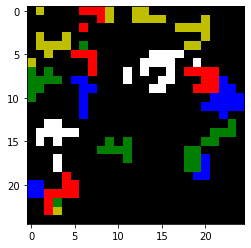

In [30]:
plt.imshow(grid, cmap = matplotlib.colors.ListedColormap(['k', 'r', 'y', 'b', 'w', 'g']));

### Cluster distances

In [31]:
def cluster_distances(clusters):
    """calculate cluster distance matrix, contains the minimum euclidean distance between 2 clusters """
    D = np.zeros((len(clusters), len(clusters)))

    # all pairwise cluster combinations
    comb = combinations([i for i in range(len(clusters))], 2)

    # for each cluster combination
    for i, j in comb:
        A = clusters[i]
        B = clusters[j]
        d_min = grid_size
        # loop over every position in each of the clusters to find the closest objects
        for k in range(len(A.objects)):
            for l in range(len(B.objects)):
                a = A.positions[k]
                b = B.positions[l]
                # euclidean distance
                d = dist(a, b)
                if d < d_min:
                    d_min = d
        # symmetric
        D[i, j] = d_min
        D[j, i] = D[i, j]
        
    return D

In [32]:
def type_distances(clusters, D):
    """calculate type distance matrix, contains the average minimum euclidean distance between 2 colors/types """
    
    # the clusters and their types
    cluster_types = [(i, int(clusters[i].objects[0])) for i in range(len(clusters))]
    
    # all types
    types = set([int(cluster.objects[0]) for cluster in clusters])

    # type distance matrix, contains the average distance between the colors/cluster types
    T = np.zeros((len(types), len(types)))

    # all pairwise type combinations, including to the same type
    comb = combinations_with_replacement(types, 2)
    
    # for each type combination
    for i, j in comb:
        # find the clusters of those types
        A = [cluster[0] for cluster in cluster_types if cluster[1] == i]
        B = [cluster[0] for cluster in cluster_types if cluster[1] == j]
        d = 0
        n = 0
        # for all combinations of those different type clusters, retrieve the distance from distance matrix
        for a in A:
            for b in B:
                d += D[a, b]
                n += 1
        # find the indices of the types in T (not always the same)
        k = [n for n in list(enumerate(types)) if n[1] == i][0][0]
        l = [n for n in list(enumerate(types)) if n[1] == j][0][0]
        # divide total distance by amount of combinations => average distance
        T[k, l] = d/n
        T[k, l] = T[k, l]
        
        if T.size > 1:
            # average distance of the red cluster to all other colored clusters (non-red)
            av_d_r_o = np.mean(T[0, 1:])
            # average distance of the red cluster to same colored clusters (red)
            av_d_r_s = np.mean(T[0, 0])
            # average distance of all clusters to all other colored clusters
            av_d_a_o = (T.sum(axis=1) - T.diagonal()).sum()/(len(types)-1)**2
            # average distance of all clusters to all same colored clusters
            av_d_a_s = np.mean(np.diagonal(T))
        else:
            av_d_r_o = 0
            av_d_r_s = 0
            av_d_a_o = 0
            av_d_a_s = 0
        
    return T, av_d_r_o, av_d_r_s, av_d_a_o, av_d_a_s

In [33]:
# making data for figures
x = [i*1000 for i in range(len(grids0))]

o_0 = []
o_1 = []
s_0 = []
s_1 = []

# non-clustered grids
for i in range(len(grids0)):
    g = grids0[i]
    clusters, cluster_grid, zero_clusters, zero_cluster_grid = calculate_clusters(g) 
    D = cluster_distances(clusters)
    T, av_d_r_o, av_d_r_s, av_d_a_o, av_d_a_s = type_distances(clusters, D)
    o_0.append(av_d_r_o)
    s_0.append(av_d_r_s)
    
# clustered grids
for i in range(len(grids1)):
    g = grids1[i]
    clusters, cluster_grid, zero_clusters, zero_cluster_grid = calculate_clusters(g) 
    D = cluster_distances(clusters)
    T, av_d_r_o, av_d_r_s, av_d_a_o, av_d_a_s = type_distances(clusters, D)
    o_1.append(av_d_r_o)
    s_1.append(av_d_r_s)

NameError: name 'grids1' is not defined

In [ ]:
# the distance between red clusters and other clusters
x = np.array(x)

width = 100
fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, o_0, width, label = "No clustering", color = 'red', alpha = 0.5, edgecolor = 'gray')
rects2 = ax.bar(x + width/2, o_1, width, label = "Clustering", color = 'gray', edgecolor = 'gray')

ax.set_ylabel('Average minimum distance')
ax.set_title('Average distance of red clusters from other clusters')
ax.legend(loc = 'upper center')
ax.grid(visible = True, linestyle = '--', linewidth=0.5)
ax.set_ylim(top = max(max(o_0), max(o_1))*1.3)

fig.tight_layout()
plt.show()

In [ ]:
# the distance between red clusters over time
x = np.array(x)

width = 100

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, s_0, width, label = "No clustering", color = 'red', alpha = 0.5, edgecolor = 'gray')
rects2 = ax.bar(x + width/2, s_0, width, label = "Clustering", color = 'gray', edgecolor = 'gray')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average minimum distance')
ax.set_title('Average distance between red clusters over time')
ax.legend(loc = 'upper center')
ax.grid(visible = True, linestyle = '--', linewidth=0.5)
ax.set_ylim(top = max(max(s_0), max(s_0))*1.3)

fig.tight_layout()

plt.show()

## Continuous vector sorting

In [34]:
# downloading iris dataset
from urllib.request import urlretrieve
import pandas as pd
iris = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
urlretrieve(iris)
df = pd.read_csv(iris, sep=',')
attributes = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
df.columns = attributes

In [35]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,4.9,3.0,1.4,0.2,Iris-setosa
1,4.7,3.2,1.3,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


In [36]:
# convert class to a number
df['class_n'] = [i[0] for j in df['class'] for i in enumerate(set(df['class'])) if j == i[1]]

In [37]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,class,class_n
0,4.9,3.0,1.4,0.2,Iris-setosa,2
1,4.7,3.2,1.3,0.2,Iris-setosa,2
2,4.6,3.1,1.5,0.2,Iris-setosa,2
3,5.0,3.6,1.4,0.2,Iris-setosa,2
4,5.4,3.9,1.7,0.4,Iris-setosa,2


In [38]:
vectors = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].to_numpy()

# normalizing the vectors
for i in range(vectors.shape[1]):
    col = vectors[:, i]
    col = (col-min(col))/max(col)
    vectors[:, i] = col

classes = df['class_n'].to_numpy()

In [39]:
# dissimilarity matrix between each sample vector
DIS = np.zeros((len(df), len(df)))

comb = combinations(df.index, 2)

for i, j in comb:
    # euclidean distance as dissimilarity measure
    DIS[i, j] = dist(vectors[i],  vectors[j])
    DIS[j, i] = DIS[i, j]
    
# normalize matrix between 0 and 1
DIS = DIS/DIS.max()

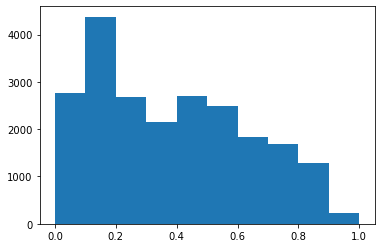

In [40]:
# distribution of the dissimilarities
plt.hist(DIS.flatten());

In [41]:
# the average dissimilarity, used in clustering
avg_dis = np.mean(DIS.flatten())
avg_dis

0.3872305692551588

In [42]:
def vector_dissimilarity(index_o, index_n, DIS):
    """calculate dissimilarity between vector objects"""
    dis = DIS[index_o - 1, index_n - 1]
    return dis

In [43]:
def vector_local_density(x, y, object, grid, alpha, DIS):
    """calculate local density
        x, y = coordinates of the cell
        object = object the ant is holding"""
    
    neighbourhood = von_neumann_neighbourhood(x, y)
    s2 = len(neighbourhood) + 1
    similarity = 0
    
    for x_n, y_n in neighbourhood:
        similarity += 1 - vector_dissimilarity(object, grid[x_n, y_n], DIS)/alpha
        
    return max(0, similarity/s2)

### Simulation

In [122]:
grid_size = 7
ant_density = 0.1
object_density = 0.25
n_object_types = len(df)
t_total = 10000
k1 = 0.05
k2 = 0.15
alpha = 0.3

In [123]:
original_grid = initiate_grid(grid_size, object_density, n_object_types)

There are 12 objects on the grid.


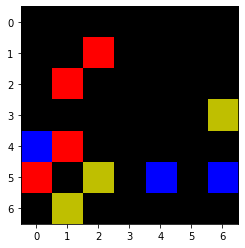

In [124]:
# color the objects according to their flower class
original_class_grid = np.zeros((grid_size, grid_size), dtype=int)
for x in range(grid_size):
    for y in range(grid_size):
        if original_grid[x, y] != 0:
            original_class_grid[x, y] = classes[original_grid[x, y] - 1] + 1
            
plt.imshow(original_class_grid, cmap = matplotlib.colors.ListedColormap(['k', 'r', 'y', 'b']));

Alpha was chosen according to the local density distribution. Several alphas were tried, the alpha that produced a distribution most similar to the one in the previous experiments was chosen.

In [125]:
alpha_densities = []
for alpha in np.arange(0.1, 2, 0.1):
    densities = []
    for vec in range(1, len(vectors) + 1):       
        for x in range(grid_size):
            for y in range(grid_size):
                densities.append(vector_local_density(x, y, vec, original_grid, alpha, DIS))
    alpha_densities.append(densities)

local density distribution for all vectors in the original grid for alpha = 0.3


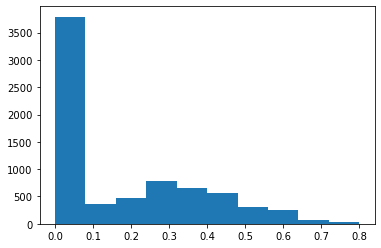

In [126]:
i = 2
plt.hist(alpha_densities[i]); 
print(f"local density distribution for all vectors in the original grid for alpha = {round(np.arange(0.1, 2, 0.1)[i], 1)}")

In [127]:
def run_vector_simulation(original_grid, ants, t_total, k1, k2, alpha, DIS):
    """the simulation for the vector clustering, based on vector_local_density"""

    grids = []
    grid = np.copy(original_grid)
    grids.append(np.copy(grid))

    for t in range(1, t_total):
        for ant in ants:

            if (ant.laden == False) & (grid[ant.x, ant.y] != 0):
                p_pickup = pickup_probability(vector_local_density(ant.x, ant.y, grid[ant.x, ant.y], grid, alpha, DIS), k1)

                if random.random() <= p_pickup:
                    ant.pickup(grid[ant.x, ant.y])
                    grid[ant.x, ant.y] = 0

            elif (ant.laden == True) & (grid[ant.x, ant.y] == 0):
                p_drop = drop_probability(vector_local_density(ant.x, ant.y, ant.object, grid, alpha, DIS), k2)

                if random.random() <= p_drop:
                    grid[ant.x, ant.y] = ant.object
                    ant.drop()

            ant.move(ants)

        if t % 1000 == 0:
            grids.append(np.copy(grid))

    # forcing ants to drop their object in place after simulation
    for ant in ants:
        while ant.laden:
            if grid[ant.x, ant.y] == 0:
                grid[ant.x, ant.y] = ant.object
                ant.drop()
            else:
                ant.move(ants)
                
    grids.append(np.copy(grid))

    return grid, grids

In [128]:
ants = initiate_ants(grid_size, ant_density)
grid, grids2 = run_vector_simulation(original_grid, ants, t_total, k1, k2, alpha, DIS)

There are 4 ants on the grid.


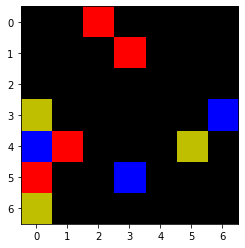

In [129]:
# color the objects according to their flower class
class_grid = np.zeros((grid_size, grid_size), dtype=int)
for x in range(grid_size):
    for y in range(grid_size):
        if grid[x, y] != 0:
            class_grid[x, y] = classes[grid[x, y] - 1] + 1
            
plt.imshow(class_grid, cmap = matplotlib.colors.ListedColormap(['k', 'r', 'y', 'b']));

### Vector clusters

In [130]:
def calculate_vector_clusters(grid, DIS):
    """Converts vector objects into clusters, adjacent objects of similar type are put into the same cluster."""
    # clusters for objects
    clusters = []
    cluster_grid = np.zeros((grid_size, grid_size), dtype=int)
    # clusters for zeros
    zero_clusters = []
    zero_cluster_grid = np.zeros((grid_size, grid_size), dtype=int)
    
    
    #iterate over all grid cells
    for x in range(grid_size):
        for y in range(grid_size):
            
            # if it's an object
            if grid[x, y] != 0:

                # if the object is not in a cluster
                if cluster_grid[x, y] == 0:

                    # make a cluster
                    clusters.append(Cluster())
                    clusters[len(clusters) - 1].add_object(x, y, grid[x, y])
                    cluster_grid[x, y] = len(clusters)

                    # add neighboring positions to the cluster using greedy search             
                    done = False
                    already_seen = []
                    while not done:
                        added = 0
                        for x_i, y_i in clusters[len(clusters) - 1].positions:
                            if (x_i, y_i) not in already_seen:
                                already_seen.append((x_i, y_i))
                                neighbors = von_neumann_neighbourhood(x_i, y_i)
                                # the dissimilarity between the vectors currently in the cluster and the adjacent vector is used
                                # to determine if the object belongs to that cluster, if the average dissimilarity is lower then 
                                # the total average dissimilarity in the dataset, the vector gets added to the cluster
                                same_type = []
                                for x_n, y_n in neighbors:
                                    if grid[x_n, y_n] != 0:
                                        dis = []
                                        for vector in clusters[len(clusters) - 1].objects:
                                            dis.append(vector_dissimilarity(vector, grid[x_n, y_n], DIS))                            
                                        if np.mean(dis) < avg_dis:
                                            same_type.append((x_n, y_n))
                                for s in same_type:
                                    clusters[len(clusters) - 1].add_object(s[0], s[1], grid[s[0], s[1]])
                                    cluster_grid[s[0], s[1]] = len(clusters)
                                    added += 1
                        if added == 0:
                            done = True

            # if it's not an object, make clusters of zeros (the free space), useful for dropping clusters later on
            else:
                # if it's is not in a cluster
                if zero_cluster_grid[x, y] == 0:

                    # make a cluster
                    zero_clusters.append(Cluster())
                    zero_clusters[len(zero_clusters) - 1].add_object(x, y, grid[x, y])
                    zero_cluster_grid[x, y] = len(zero_clusters)

                    # add neighboring positions to the cluster using greedy search
                    done = False
                    already_seen = []
                    while not done:
                        added = 0
                        for x_i, y_i in zero_clusters[len(zero_clusters) - 1].positions:
                            if (x_i, y_i) not in already_seen:
                                already_seen.append((x_i, y_i))
                                neighbors = von_neumann_neighbourhood(x_i, y_i)
                                same_type = [n for n in neighbors if grid[n[0], n[1]] == 0]
                                for s in same_type:
                                    zero_clusters[len(zero_clusters) - 1].add_object(s[0], s[1], grid[s[0], s[1]])
                                    zero_cluster_grid[s[0], s[1]] = len(zero_clusters)
                                    added += 1
                        if added == 0:
                            done = True

        
                          
    return clusters, cluster_grid, zero_clusters, zero_cluster_grid

In [131]:
clusters, cluster_grid, zero_clusters, zero_cluster_grid = calculate_vector_clusters(grid, DIS)

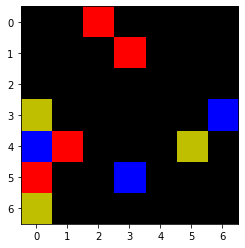

In [132]:
# color the objects according to their flower class
class_grid = np.zeros((grid_size, grid_size), dtype=int)
for x in range(grid_size):
    for y in range(grid_size):
        if grid[x, y] != 0:
            class_grid[x, y] = classes[grid[x, y] - 1] + 1
            
plt.imshow(class_grid, cmap = matplotlib.colors.ListedColormap(['k', 'r', 'y', 'b']));

In [133]:
len(clusters)

9

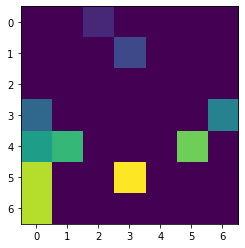

In [134]:
plt.imshow(cluster_grid);

In [135]:
len(zero_clusters)

1

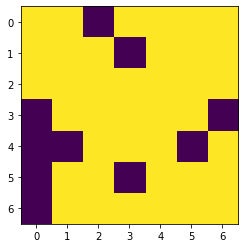

In [136]:
plt.imshow(zero_cluster_grid);

In [137]:
def vector_Von_Neumann_drop(ant, grid, alpha, DIS): 
    """Von Neumann drop method to drop clusters of vectors"""
    success = True
    
    #get location of ant
    x, y = ant.x, ant.y
    
    previous_positions = [(x, y)]
    
    #virtual drop of first object in cluster
    temp_grid = np.copy(grid)
    temp_grid[x, y] = ant.object.objects[0]
    
    #iterative virtual drops of next objects in cluster
    for i in range(1, len(ant.object.objects)):
        
        #get location of all neighbours
        neighbours = von_neumann_neighbourhood(x, y)
        max_s = 0
        max_x = float("nan")
        max_y = float("nan")

        #iterate over neighbours
        for x_n, y_n in neighbours:
            #if cell is empty 
            if temp_grid[x_n, y_n] == 0:
                #calculate local density of next object in cluster
                s = vector_local_density(x_n, y_n, ant.object.objects[i], temp_grid, alpha, DIS)
                #check if this neighbour is the current best neighbour
                if s > max_s:
                    max_s = s
                    max_x = x_n
                    max_y = y_n
        
        if np.isnan(max_x) != True:
            #virtual drop of object on best neighbour
            temp_grid[max_x, max_y] = ant.object.objects[i]
        
            #"move" to the best neighbour
            x = max_x
            y = max_y
            previous_positions = [(max_x, max_y)]
            i = 0
            
        else:
            success = False
            break
            
    return success, temp_grid

In [138]:
def average_local_dissimilarity(ant, grid, DIS):
    """calculate the average dissimilarity of the neighbours to the cluster"""
    x, y, cluster = ant.x, ant.y, ant.cluster
    neighbours = von_neumann_neighbourhood(x, y)
    avg_l_dis = []
    for x_n, y_n in neighbors:
        dis= []
        if grid[x_n, y_n] != 0:
            for vector in cluster.objects:
                dis.append(vector_dissimilarity(vector, grid[x_n, y_n], DIS))
        avg_l_dis.append(np.mean(dis))
    avg_l_dis = np.mean(avg_dis)
    return avg_l_dis

In [139]:
def run_vector_cluster_simulation(original_grid, ants, t_total, k1, k2, alpha, DIS):

    grids = []
    grid = np.copy(original_grid)
    grids.append(np.copy(grid))
    clusters, cluster_grid, zero_clusters, zero_cluster_grid = calculate_vector_clusters(grid, DIS)
    ant_timer = 0
    maxtime = grid_size**2

    for t in range(1, t_total):

        # keep track of how many timesteps no clusters are dropped for surrounded cluster deadlock
        ant_timer += 1

        for ant in ants:

            # pickup
            if (ant.laden == False) and (grid[ant.x, ant.y] != 0):     

                # make sure ant doesn't pick up the last cluster of that type to avoid empty grid deadlock
                if sum([grid[ant.x, ant.y] == cluster.objects[0] for cluster in clusters]) > 1: 

                    p_pickup = pickup_probability(vector_local_density(ant.x, ant.y, grid[ant.x, ant.y], grid, alpha, DIS), k1)            
                    if random.random() <= p_pickup:
                        cluster = clusters[int(cluster_grid[ant.x, ant.y]) - 1]
                        ant.pickup(cluster)          

                        # remove cluster & objects from the grid
                        for i in range(len(cluster.positions)):
                            grid[cluster.x[i], cluster.y[i]] = 0     

            # drop
            elif (ant.laden == True) and (grid[ant.x, ant.y] == 0):          
                p_drop = drop_probability(vector_local_density(ant.x, ant.y, ant.object.objects[0], grid, alpha, DIS), k2)     
                if random.random() <= p_drop: 

                    # find the zero cluster that the ant is currently in
                    for zero_cluster in zero_clusters:
                         if (ant.x, ant.y) in zero_cluster.positions:
                            break

                    # only drop if the free space (zero cluster) is large enough to hold the cluster that the ant is carrying
                    if len(ant.object.objects) <= len(zero_cluster.objects):
                        # Neumann drop the cluster             
                        success, temp_grid = vector_Von_Neumann_drop(ant, grid, alpha, DIS)
                        if success:
                            grid = np.copy(temp_grid)
                            ant.drop()
                            ant_timer = 0

            # if no clusters have been dropped for too long, force ants to walk around until they drop their clusters
            # to avoid surrounded cluster deadlock
            if ant_timer == maxtime:
                ant_timer = 0
                for ant in ants:
                    if ant.laden:        
                        success = False
                        while not success:
                            ant.move(ants)
                            # make sure the grid is empty and the ant is adjacent to a similar
                            if grid[ant.x, ant.y] == 0 and average_local_dissimilarity(ant, grid, DIS) < avg_dis:                
                                # find the zero cluster that the ant is currently in
                                for zero_cluster in zero_clusters:
                                    if (ant.x, ant.y) in zero_cluster.positions:
                                        break    
                                # only drop if the free space (zero cluster) is large enough to hold the cluster that the ant is carrying
                                if len(ant.object.objects) <= len(zero_cluster.objects):
                                    # Neumann drop the cluster             
                                    success, temp_grid = vector_Von_Neumann_drop(ant, grid, alpha, DIS)
                        grid = np.copy(temp_grid)
                        ant.drop()
                        clusters, cluster_grid, zero_clusters, zero_cluster_grid = calculate_vector_clusters(grid, DIS)

            ant.move(ants)
            # merge adjacent clusters of same type by recalculating
            clusters, cluster_grid, zero_clusters, zero_cluster_grid = calculate_clusters(grid)

        if t % 1000 == 0:
            grids.append(np.copy(grid))

    # force the ants to drop at the end of the simulation
    for ant in ants:
        if ant.laden:        
            success = False
            while not success:
                ant.move(ants)
                # make sure the grid is empty and the ant is adjacent to a similar cluster
                if grid[ant.x, ant.y] == 0 and  average_local_dissimilarity(ant, grid, DIS) < avg_dis:          
                    # find the zero cluster that the ant is currently in
                    for zero_cluster in zero_clusters:
                        if (ant.x, ant.y) in zero_cluster.positions:
                            break    
                    # only drop if the free space (zero cluster) is large enough to hold the cluster that the ant is carrying
                    if len(ant.object.objects) <= len(zero_cluster.objects):
                        # Neumann drop the cluster             
                        success, temp_grid = vector_Von_Neumann_drop(ant, grid, alpha, DIS)
            grid = np.copy(temp_grid)
            ant.drop()
            clusters, cluster_grid, zero_clusters, zero_cluster_grid = calculate_vector_clusters(grid, DIS)
    
    grids.append(np.copy(grid))
        
    return grid, grids

In [140]:
ants = initiate_ants(grid_size, ant_density)
grid, grids3 = run_vector_cluster_simulation(original_grid, ants, t_total, k1, k2, alpha, DIS)

There are 4 ants on the grid.


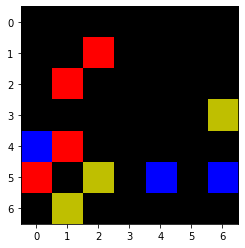

In [141]:
class_grid = np.zeros((grid_size, grid_size), dtype=int)
for x in range(grid_size):
    for y in range(grid_size):
        if grid[x, y] != 0:
            class_grid[x, y] = classes[grid[x, y] - 1] + 1
            
plt.imshow(class_grid, cmap = matplotlib.colors.ListedColormap(['k', 'r', 'y', 'b']));

In [153]:
# making data for figures
x = [i*1000 for i in range(len(grids2))]

o_2 = []
o_3 = []
s_2 = []
s_3 = []

# non-clustered grids
for i in range(len(grids2)):
    g = grids2[i]    
    # we have to calculate the real clusters according to flower class, not according to the vector clusters
    class_g = np.zeros((grid_size, grid_size), dtype=int)
    for x in range(grid_size):
        for y in range(grid_size):
            if g[x, y] != 0:
                class_g[x, y] = classes[g[x, y] - 1] + 1
    clusters, cluster_grid, zero_clusters, zero_cluster_grid = calculate_clusters(g)    
    D = cluster_distances(clusters)
    T, av_d_r_o, av_d_r_s, av_d_a_o, av_d_a_s = type_distances(clusters, D)
    o_2.append(av_d_r_o)
    s_2.append(av_d_r_s)
    
# clustered grids
for i in range(len(grids3)):
    g = grids3[i]    
    # we have to calculate the real clusters according to flower class, not according to the vector clusters
    class_g = np.zeros((grid_size, grid_size), dtype=int)
    for x in range(grid_size):
        for y in range(grid_size):
            if g[x, y] != 0:
                class_g[x, y] = classes[g[x, y] - 1] + 1
    clusters, cluster_grid, zero_clusters, zero_cluster_grid = calculate_clusters(g)     
    D = cluster_distances(clusters)
    T, av_d_r_o, av_d_r_s, av_d_a_o, av_d_a_s = type_distances(clusters, D)
    o_3.append(av_d_r_o)
    s_3.append(av_d_r_s)

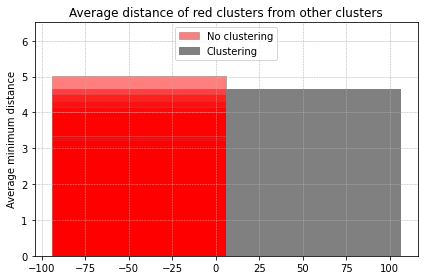

In [154]:
# the distance between red clusters and other clusters
x = np.array(x)

width = 100
fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, o_2, width, label = "No clustering", color = 'red', alpha = 0.5, edgecolor = 'gray')
rects2 = ax.bar(x + width/2, o_3, width, label = "Clustering", color = 'gray', edgecolor = 'gray')

ax.set_ylabel('Average minimum distance')
ax.set_title('Average distance of red clusters from other clusters')
ax.legend(loc = 'upper center')
ax.grid(visible = True, linestyle = '--', linewidth=0.5)
ax.set_ylim(top = max(max(o_0), max(o_1))*1.3)

fig.tight_layout()
plt.show()

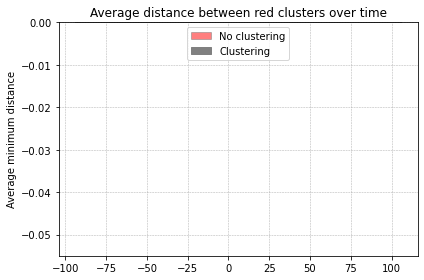

In [156]:
# the distance between red clusters over time
x = np.array(x)

width = 100

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, s_2, width, label = "No clustering", color = 'red', alpha = 0.5, edgecolor = 'gray')
rects2 = ax.bar(x + width/2, s_3, width, label = "Clustering", color = 'gray', edgecolor = 'gray')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average minimum distance')
ax.set_title('Average distance between red clusters over time')
ax.legend(loc = 'upper center')
ax.grid(visible = True, linestyle = '--', linewidth=0.5)
ax.set_ylim(top = max(max(s_0), max(s_0))*1.3)

fig.tight_layout()

plt.show()